# Wind farm integration

An example of a wind farm offering firm power by estimating the expected wind resource and then using a MPC to jointly optimize control of a small gas turbine and storage.

In [5]:
%matplotlib inline
import datetime
import pandas as pd
import matplotlib
import numpy as np
import cvxpy as cvx
from matplotlib import pyplot as plt

from dem import *

matplotlib.rc("figure", figsize=(16,6))
matplotlib.rc("lines", linewidth=2)

## Wind resource

Data is from [NREL wind integration dataset](http://www.nrel.gov/electricity/transmission/wind_toolkit.html), site 20182.

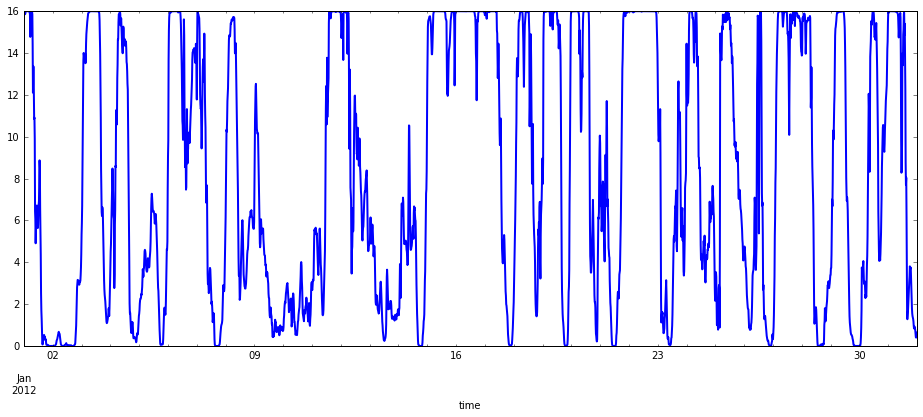

In [2]:
def read_wind_csv(filename):
    df = pd.read_csv(
        filename, 
        skiprows=3, 
        parse_dates=[[0,1,2,3,4]],
        date_parser=lambda *cols: datetime.datetime(*map(int, cols)),
        index_col=0)
    df.index.name = "time"
    return df

wind = pd.concat([
        read_wind_csv("nrel_wind/20182-2011.csv"),
        read_wind_csv("nrel_wind/20182-2012.csv")])
p_wind = wind["power (MW)"].resample("15min").mean()
p_wind["2012-01"].plot()

### Power blocks

The amount of power offered for sale

(0, 16)

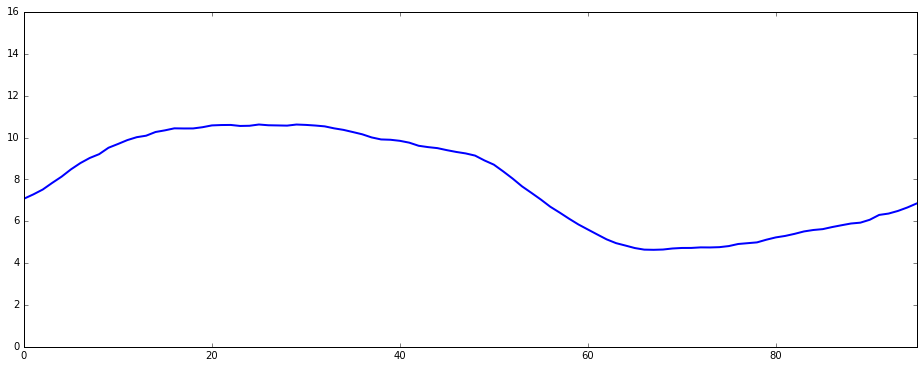

In [3]:
def interval_of_day(dt):
    return dt.hour*4 + dt.minute/15

# compute target output
p_wind_by_interval = p_wind.groupby(interval_of_day(p_wind.index)).mean()
p_wind_mean = pd.Series([p_wind_by_interval[interval_of_day(x)] for x in p_wind.index], index=p_wind.index)

p_wind_by_interval.plot()
plt.ylim([0,16])

## MPC

### Autoregressive model

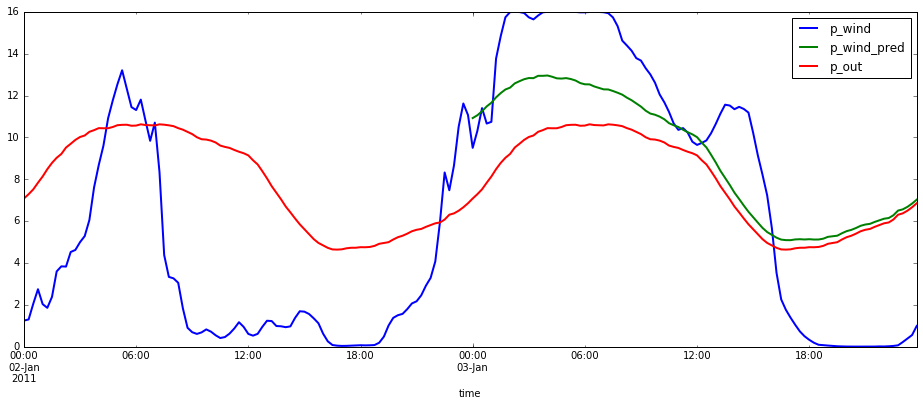

In [32]:
from sklearn import linear_model

H = 4*6
p_wind_residual = p_wind - p_wind_mean
X = np.hstack([p_wind_residual.shift(x).fillna(0).reshape(-1,1) for x in xrange(1,H+1)])
lr = linear_model.RidgeCV()
lr.fit(X, p_wind_residual)

def predict_wind(t, T):
    r = np.zeros(T)
    x = X[t,:]
    for i in xrange(T):
        tau = t+i
        r[i] = lr.predict(x.reshape(1,-1))
        x = np.hstack((r[i], x[:-1]))
    return np.maximum(p_wind_mean[t:t+T] + r, 0)

t = 4*24*2
T = 4*24
compare = pd.DataFrame(index=p_wind.index)
compare["p_wind"] = p_wind
compare["p_wind_pred"] = pd.Series(predict_wind(t, T), index=p_wind.index[t:t+T])
compare["p_out"] = p_wind_mean
compare["2011-01-02":"2011-01-03"].plot()

In [9]:
from dem import network
from dem import devices
reload(network)
reload(devices)

CurtailableLoad = devices.CurtailableLoad
DeferrableLoad = devices.DeferrableLoad
FixedLoad = devices.FixedLoad
Generator = devices.Generator
Group = network.Group
Net = network.Net
Storage = devices.Storage
ThermalLoad = devices.ThermalLoad
TransmissionLine = devices.TransmissionLine

run_mpc = network.run_mpc

In [43]:
T = 4*24
out = FixedLoad(power=Parameter(T+1), name="Output")
wind_gen = Generator(alpha=0, beta=0, power_min=0, power_max=Parameter(T+1), name="Wind")
gas_gen = Generator(alpha=0.02, beta=1, power_min=0.01, power_max=1, name="Gas")
storage = Storage(discharge_max=1, charge_max=1, energy_max=12*4, energy_init=Parameter(1, value=6*4))
net = Net([wind_gen.terminals[0], 
           gas_gen.terminals[0],
           storage.terminals[0], 
           out.terminals[0]])
network = Group([wind_gen, gas_gen, storage, out], [net])
network.init_problem(time_horizon=T+1)

def predict(t):
    out.power.value = p_wind_mean[t:t+T+1].as_matrix()/16
    wind_gen.power_max.value = np.hstack((p_wind[t], predict_wind(t+1,T)))/16

def execute(t):
    energy_stored[t] = storage.energy.value[0]
    storage.energy_init.value = storage.energy.value[0]

N = 4*24*7
energy_stored = np.empty(N)
results = run_mpc(network, N, predict, execute)

100%|██████████| 672/672 [00:33<00:00, 20.31it/s]


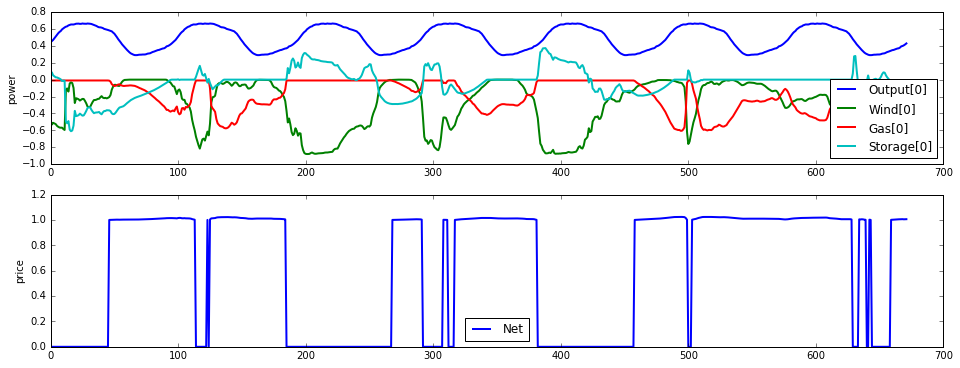

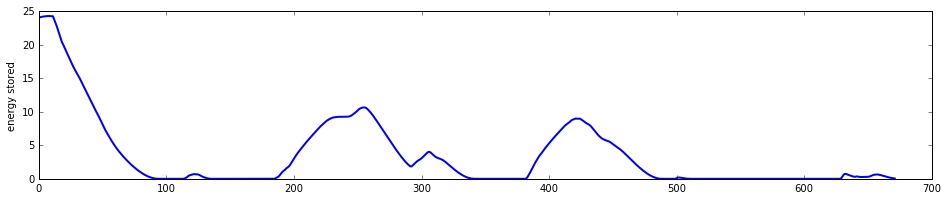

In [44]:
# plot the results
results.plot()

# plot energy stored in battery
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,3))
ax.plot(energy_stored)
ax.set_ylabel("energy stored")

### Wind curtailment

Current model is not too smart about using all the available wind power, at times it doesn't even charge the battery when there is extra power available...

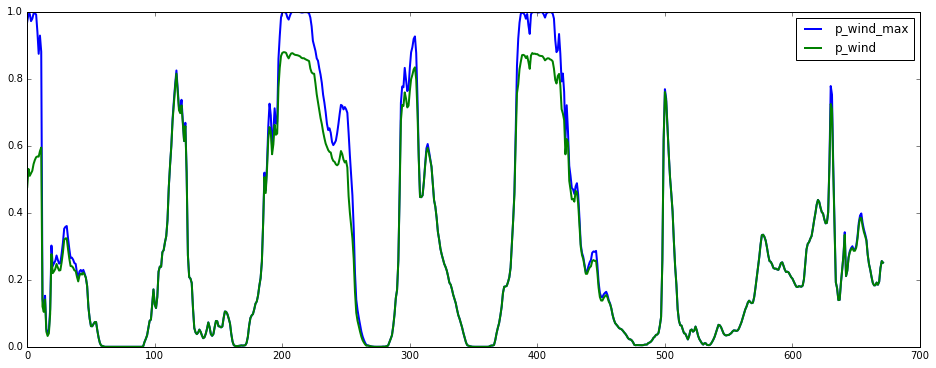

In [45]:
plt.plot(xrange(N), p_wind[:N]/16, label="p_wind_max")
plt.plot(-results.power[(wind_gen, 0)], label="p_wind")
plt.legend()